Basic Agents using tabular learning methods. Completed February 2021 by Annik Carson

In [ ]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

import os
print(os.getcwd())

# we have offloaded our classes defined previously to py files which we need to import here to use in this notebook 
from google.colab import drive
drive.mount('/content/drive')
import sys

sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Basics of Reinforcement Learning/') ## will have to change this path! 

# import premade Gridworlds from Week2 Tutorial
from pyfiles.GridworldEnvs import BoundedGridworld, EdgewrapGridworld, CliffWorld

# import utility functions
from pyfiles.Utils import running_mean as rm
from pyfiles.Utils import oneD2twoD

/content


# Making More Sophisticated Agents
Last time we made an agent which just selects actions randomly. If we want a more principled way to choose actions, we want to design an agent which can take advantage of its experience to choose actions better than random.

In [ ]:
# here is a pretty generic outline for the agent class -- most importantly an 
# agent needs a function for selecting what action to take in the environment. 
# we may also want to add other things like some data structures for storing what
# it has experienced (ex. what rewards it has encountered?)

class RandomAgent(object):
  def __init__(self, num_actions):
    self.num_actions = num_actions
  def select_action(self, state):
    # state actually does nothing in this agent, but we will want our action selection
    # in later agents to be based on the state we're in
    action = np.random.choice(self.num_actions)
    return action


In [ ]:
class Q_Agent(object):
  def __init__(self, env, learning_rate=0.1, discount=0.95, epsilon=1.0):
    self.num_actions = env.nactions
    self.action_space = np.arange(self.num_actions)

    # this agent selects actions from a table of state,action values which we initalize randomly
    self.q_table = np.random.uniform(low=-2, high=0, size=(env.nstates, env.nactions))

    # parameters for learning
    self.epsilon       = epsilon
    self.learning_rate = learning_rate
    self.discount      = discount

  def choose_action(self, state):
    # this agent uses epsilon-greedy action selection, meaning that it selects 
    # the greedy (highest value) action most of the time, but with epsilon probability
    # it will select a random action -- this helps encourage the agent to explore
    # unseen trajectories
    if np.random.random()>self.epsilon:
      # take the action which corresponds to the highest value in the q table at that row (state)
      action = np.argmax(self.q_table[state]) 
    else:
      action=np.random.choice(self.action_space)
    return action


  def update_q_table(self, current_state, current_action, reward, new_state):
    # this function describes how the Q table gets updated so the agent can make 
    # better choices based on what it has experienced from the environment 
    current_q = self.q_table[ current_state, current_action]
    max_future_q = np.max(self.q_table[new_state,:])
    
    new_q = (1-self.learning_rate)*current_q + self.learning_rate*(reward + self.discount*max_future_q)
    self.q_table[current_state, current_action] = new_q


In [ ]:
#SARSA agent class
class SARSA_Agent(Q_Agent):
  def __init__(self, env, learning_rate=0.1, discount=0.95, epsilon=1.0):
    super().__init__(env, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

  #updates q values after each step 
  # similar to Q update but with one key difference -- we use the action we *actually* took
  # rather than guessing we took the max value action
  # with epsilon probability, we will have actually taken a random action, so SARSA wants to account for that 
  def update_q_table(self,current_state, current_action, reward, next_state, next_action):
    current_q = self.q_table[ current_state, current_action]
    future_q = self.q_table[ next_state, next_action] # np.max(self.q_table[new_state,:])
    
    new_q = (1-self.learning_rate)*current_q + self.learning_rate*(reward + self.discount*future_q)
    self.q_table[current_state, current_action] = new_q



# Set up functions for navigating environment


Because SARSA and Q update differently, we need to write slightly different functions to navigate the environment

In [ ]:
def q_navigate(env, q_agent, num_episodes, random_start=False, start=0):
  # set how we will decay the randomness of action selection over the course of training
  start_eps_decay = 1
  end_eps_decay = num_episodes//2
  epsilon_decay_value = q_agent.epsilon/(end_eps_decay-start_eps_decay)

  # initialize empty list for keeping track of rewards achieved per episode
  reward_tracking=[]
  max_steps= 1000

  for episode in range(num_episodes):
    # initalize reward counter
    total_reward=0
    
    # get first state and action
    if random_start:
      state=np.random.choice(env.nstates)
    else:
      state=start
    
    for step in range(max_steps):
      action = q_agent.choose_action(state)
      # take a step in the environment
      next_state, reward, done = env.move(state, action)

      total_reward+=reward

      if not done:
        q_agent.update_q_table(state, action, reward, next_state)
      else:
        q_agent.q_table[state, action] = 0
        break
      state=next_state
    
    reward_tracking.append(total_reward)
    
    if end_eps_decay >= episode >= start_eps_decay:
      q_agent.epsilon -= epsilon_decay_value

  return reward_tracking

def sarsa_navigate(env, sarsa_agent, num_episodes, random_start=False, start=0): # takes sarsa_agent as input 
#-- will not work w Q_agent bc takes additional argument of next_state in update_q_table function
  # set how we will decay the randomness of action selection over the course of training
  start_eps_decay = 1
  end_eps_decay = num_episodes//2
  epsilon_decay_value = sarsa_agent.epsilon/(end_eps_decay-start_eps_decay)

  # initialize empty list for keeping track of rewards achieved per episode
  reward_tracking=[]
  max_steps= 1000

  for episode in range(num_episodes):
    # initalize reward counter
    total_reward=0
    
    # get first state and action
    if random_start:
      state=np.random.choice(env.nstates)
    else:
      state=start
    action = sarsa_agent.choose_action(state)

    for step in range(max_steps):
      # take a step in the environment
      next_state, reward, done = env.move(state, action)

      total_reward+=reward

      if not done:
        next_action = sarsa_agent.choose_action(next_state)
        sarsa_agent.update_q_table(state, action, reward, next_state, next_action)
      else:
        sarsa_agent.q_table[state, action] = 0
        break
      state=next_state
      action=next_action
    
    reward_tracking.append(total_reward)
    
    if end_eps_decay >= episode >= start_eps_decay:
      sarsa_agent.epsilon -= epsilon_decay_value

  return reward_tracking


# Experiment with Q Agent and SARSA Agent in Different Environments

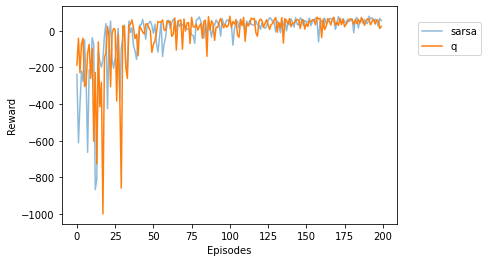

In [ ]:
# make an instance of the bounded gridworld environment (here imported from ./pyfiles/GridworldEnvs)
env_shape = (10,10)
num_actions = 4
env = BoundedGridworld(env_shape,num_actions)

q_agent = Q_Agent(env)
sarsa_agent = SARSA_Agent(env)

num_episodes = 200 
random_start = False

q_performance = q_navigate(env, q_agent, num_episodes, random_start)
sarsa_performance = sarsa_navigate(env, sarsa_agent, num_episodes, random_start)

plt.figure()
plt.plot(sarsa_performance, alpha=0.5, label="sarsa")
plt.plot(q_performance, label="q")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

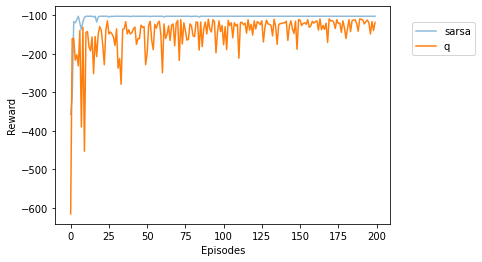

In [ ]:
# make an instance of the cliffworld environment (here imported from ./pyfiles/GridworldEnvs)
env_shape = (10,10)
num_actions = 4
env = CliffWorld(env_shape,num_actions)

q_agent = Q_Agent(env,epsilon=0.1)
sarsa_agent = SARSA_Agent(env,epsilon=0.1)

num_episodes = 200 
random_start = False

q_performance = q_navigate(env, q_agent, num_episodes, random_start)
sarsa_performance = sarsa_navigate(env, sarsa_agent, num_episodes, random_start, start=env.nstates-env.shape[1]) # start at bottom left corner 

plt.figure()
plt.plot(sarsa_performance, alpha=0.5, label="sarsa")
plt.plot(q_performance, label="q")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

# Manipulations to Agent Parameters
Focusing just on the Q-learning agent, manipulate the following parameters and observe the effects: 

*   Learning Rate
*   Discount Factor
*   Epsilon 
    - Starting value 
    - Minimum / final value
    - Rate of decay
    - Decay function (currently linear) 



In [ ]:
# make an environment we will do our tests on
env_shape = (10,10)
num_actions = 4
env = BoundedGridworld(env_shape,num_actions)

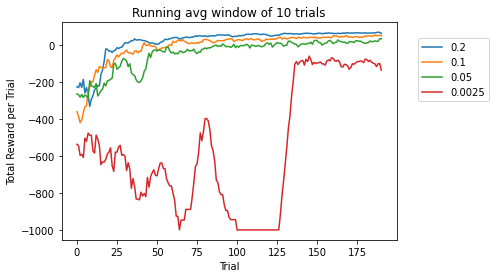

In [ ]:
#make several copies of the Q learner with different learning rates 
agents = {} # we will store these different agents in a dictionary with keys corresponding to their Learning rate 
learning_rates_to_test = [0.2, 0.1, 0.05, 0.0025]


for lr in learning_rates_to_test:
  agents[f'{lr}'] = Q_Agent(env,learning_rate=lr) 

num_episodes = 200
random_start = False
results = {}
for lr, agent in agents.items():
  results[lr] = q_navigate(env, agent, num_episodes, random_start)

plt.figure()
for lr in agents:
  smoothing = 10
  averaged_results = rm(results[lr], smoothing)
  plt.plot(averaged_results, alpha=1, label=f'{lr}')

plt.title(f'Running avg window of {smoothing} trials')
plt.ylabel('Total Reward per Trial')
plt.xlabel('Trial')
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.show()

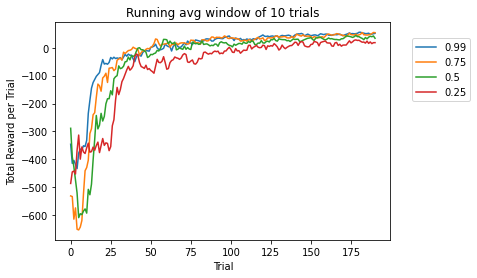

In [ ]:
#make several copies of the Q learner with different discount factors  
agents = {} 
discount_factors_to_test = [0.99, 0.75, 0.5, 0.25]

for gamma in discount_factors_to_test:
  agents[f'{gamma}'] = Q_Agent(env,discount=gamma) 

num_episodes = 200
random_start = False
results = {}
for gamma, agent in agents.items():
  results[gamma] = q_navigate(env, agent, num_episodes, random_start)

plt.figure()
for gamma in agents:
  smoothing = 10
  averaged_results = rm(results[gamma], smoothing)
  plt.plot(averaged_results, alpha=1, label=f'{gamma}')

plt.title(f'Running avg window of {smoothing} trials')
plt.ylabel('Total Reward per Trial')
plt.xlabel('Trial')
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.show()

In [ ]:
# test with different rates of decay of epsilon (i.e. different linear decay)

# test with different decay function (i.e. exponential decay; sigmoidal decay)

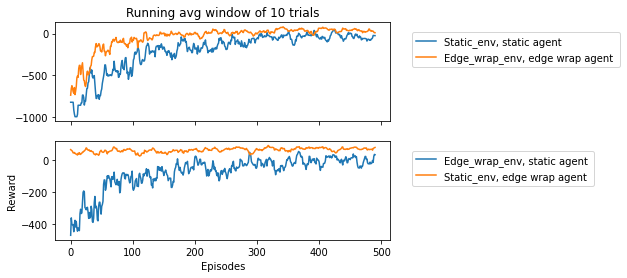

In [ ]:
# train two Q learners - one in edgewrapping gridworld and one in bounded gridworld
# after training, switch them -- how does their performance change when the 
# wrap_trained_agent is put in the bound_environment and vice versa?

#introducing trained agents to a new environment
env_shape = (20,20)
num_actions = 4

# make environments 
edge_wrap_env = EdgewrapGridworld(env_shape,num_actions)
bounded_env = BoundedGridworld(env_shape,num_actions)

# make agents to train 
edge_wrap_agent = Q_Agent(edge_wrap_env)
bounded_agent = Q_Agent(bounded_env)

# set training parameters 
num_episodes = 500
random_start = True
# training phase 1 - novel environment
a1 = q_navigate(bounded_env,bounded_agent,num_episodes,random_start)
a2 = q_navigate(edge_wrap_env,edge_wrap_agent,num_episodes,random_start)

# training phase 2 - swapped environment 
b1 = q_navigate(bounded_env,edge_wrap_agent,num_episodes,random_start)
b2 = q_navigate(edge_wrap_env,bounded_agent,num_episodes,random_start)

fig,ax=plt.subplots(2,1, sharex=True)
smoothing = 10 
ax[0].plot(rm(a1,smoothing), label="Static_env, static agent")
ax[0].plot(rm(a2,smoothing), label="Edge_wrap_env, edge wrap agent ")
ax[1].plot(rm(b1,smoothing), label="Edge_wrap_env, static agent")
ax[1].plot(rm(b2,smoothing), label="Static_env, edge wrap agent ")
ax[0].legend(bbox_to_anchor=(1.05, 0.95))
ax[1].legend(bbox_to_anchor=(1.05, 0.95))
ax[1].set_ylabel("Reward")
ax[1].set_xlabel("Episodes")
ax[0].set_title(f'Running avg window of {smoothing} trials')
plt.show()


In [ ]:
def get_preferred_action(env_shape, q_table):
  pref_action = np.empty(env_shape)

  for ind, q_vals in enumerate(q_table):
    coord = oneD2twoD(env_shape, ind)
    pref_action[coord] = np.argmax(q_vals)
  
  return pref_action

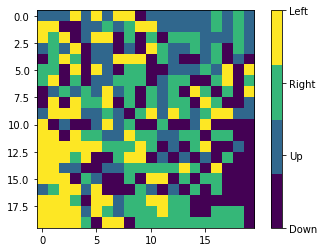

In [ ]:
# print out preferred action from each state after learning
pref_action = get_preferred_action(edge_wrap_env.shape, bounded_agent.q_table)

plt.figure()
cmap=cm.get_cmap("viridis", 4)
a= plt.imshow(pref_action, cmap=cmap)
cbar=colorbar(a,ticks=[0,1,2,3])
cbar.ax.set_yticklabels(['Down','Up','Right','Left'])
plt.show()